## This moment looks at the relationship between Zernike and geometric moments and solutions to the Zernike moments/invariants system

### Connection between Zernike and geometric moments

In [1]:
import numpy as np
import sympy

from milad import analytic
from milad import geometric
from milad import invariants
from milad import zernike

sympy.init_printing()

In [2]:
max_order = 3
phi = invariants.read(invariants.COMPLEX_INVARIANTS, max_order=max_order)

In [3]:
O = sympy.IndexedBase('\Omega', complex=True) # The Zernike moment symbols
P = sympy.IndexedBase('\Phi', complex=False) # The invariants, phi, symbols
m = sympy.IndexedBase('m', real=True) # Geometric moment symbols

Let's get the polynomials linking $\Phi$ and $\Omega$

In [4]:
system = [] # The system of equations
for idx, entry in enumerate(phi):
    system.append(entry.apply(O) - P[idx + 1])

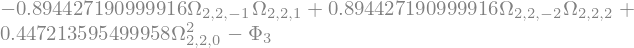

In [43]:
system[2]

Now, let's find the Zernike moments that aren't in our system of invariants

In [44]:
all_symbols = set()
for indices in zernike.iter_indices(max_order, redundant=True):
    all_symbols.add(O[indices])

free_symbols = set()
for eq in system:
    for symbol in eq.free_symbols:
        if isinstance(symbol, sympy.Indexed) and symbol.base == O:
            free_symbols.add(symbol)
            
            
diff = all_symbols - free_symbols
diff

Here we see that the 1$^{st}$ order moments are 'missing'.  This is intentional as these encode global translation and we're assuming environments to be centred in which case these moments are 0.
Let's have a look at the connection to the geometric moments:

In [45]:
symbols_array = np.array(analytic.create_array(m, (max_order + 1, max_order + 1, max_order + 1)), dtype=object)
geom_moments = geometric.GeometricMoments(symbols_array)
z_from_g = zernike.from_geometric_moments(max_order, geom_moments)

In [46]:
diff_list = list(diff)

dict(zip(diff_list, tuple(z_from_g[mom.indices] for mom in diff_list)))

In [47]:
z_from_g[2,0,0], z_from_g[2,2,1], z_from_g[2,2,2]

We see that these contain three moments corresponding to sums of the $x$, $y$ and $z$ coordinates respectively which will naturally be 0 if the system is centred.

### Solving for Zernike moments from invariants

Let's look at the difference in the number of equations vs number of unknowns:

In [48]:
print(f'Free symbols: {len(free_symbols)}')
print(f'Number of Phi: {len(phi)}')
free_symbols

Free symbols: 17
Number of Phi: 14


As expected there are three fewer equations than the number of unknowns.  What's more, any moments $\Omega_{n0}^0$ are absolute invariants and therefore do not interact with the other moments so we don't need to solve for them.

In [49]:
indep_symbols = set()
redundant = set()
for entry in list(free_symbols):
    indices = entry.indices
    if indices[1] == indices[2] == 0:
        redundant.add(entry)
    else:
        indep_symbols.add(entry)
len(indep_symbols), indep_symbols

Let's remove the reundant equations to make the life of the solver easier

In [50]:
to_solve = []
for eqn in system:
    found = False
    for symbol in redundant:
        if symbol in eqn.free_symbols:
            found = True
            break
    if not found:
        to_solve.append(eqn)


# Let's add the relationships between positive and negative $m$ values
symbols_left = set()
for symbol in indep_symbols:
    m_value = symbol.indices[2]
    if m_value < 0:
        symb = symbol.base[symbol.indices[0], symbol.indices[1], -m_value]
        sym = (-1)**(-m_value) * sympy.conjugate(symb)
        for i, eqn in enumerate(to_solve):
            to_solve[i] = eqn.subs(symbol, sym)
#         to_solve.append(symbol - (-1)**m_value * sympy.conjugate(sym))
    else:
        symbols_left.add(symbol)

len(to_solve), len(symbols_left), symbols_left

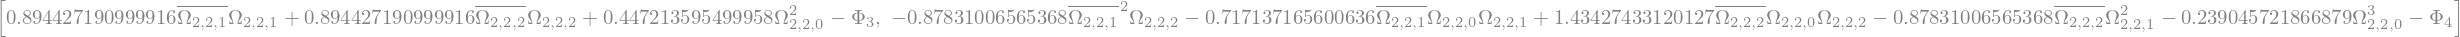

In [51]:
reduced_eqns = list(to_solve)
soln = sympy.nonlinsolve(reduced_eqns[:1], (O[2, 2, 0],))
reduced_eqns[:2]

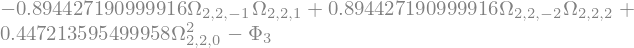

In [52]:
system[2]

Now, let's try and solve the system of the remaining unknowns

In [ ]:
solve_for = list(symbols_left)
print("Solving for {}".format(solve_for))
soln = sympy.nonlinsolve(to_solve, solve_for)

In [ ]:
to_solve[4]

In [ ]:
solutions = list(soln)
print(solve_for[0])
solutions[0][0]

In [ ]:
sympy.simplify(to_solve[1].subs(solve_for[0], solutions[0][0]))
# solve_for[0].subs(solve_for[0], solutions[0][0])

In [ ]:
find_symbols = list(symbols_left - set((O[2, 2, 2], O[2, 2, 1], O[2, 2, 0])))
soln3 = sympy.nonlinsolve(to_solve[2:], find_symbols)